In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split 
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Flatten

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


# Load Dataset

In [2]:
messages = pd.read_csv('spam.csv',encoding = 'latin-1')
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
messages

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "message"]

# Exploratory Data Analysis

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
#Count the frequency of top 5 messages.
messages['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4
4,"Wen ur lovable bcums angry wid u, dnt take it ...",4


# Data Visualization

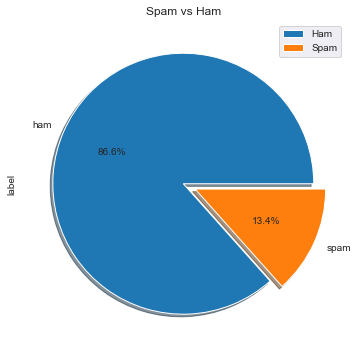

In [10]:
messages["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Text(0, 0.5, 'Frequency')

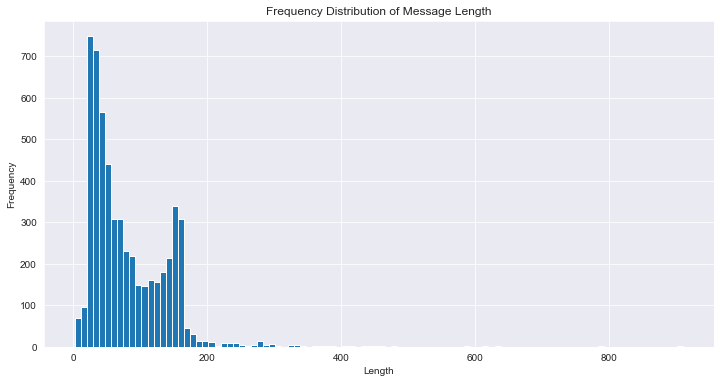

In [11]:
plt.figure(figsize=(12,6))
messages['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

In [12]:
messages['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

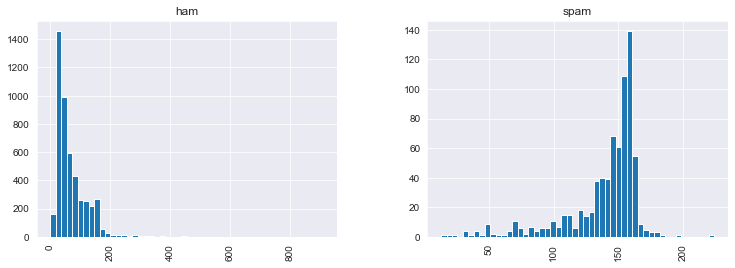

In [13]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

# Text Preprocessing

In [14]:
def text_preprocess(mess):
  
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    return nostop

In [15]:
spam_messages = messages[messages["label"] == "spam"]["message"]
ham_messages = messages[messages["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  747
No of ham messages :  4825


In [16]:
spam_words = text_preprocess(spam_messages)

In [17]:
spam_words[:10]

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may']

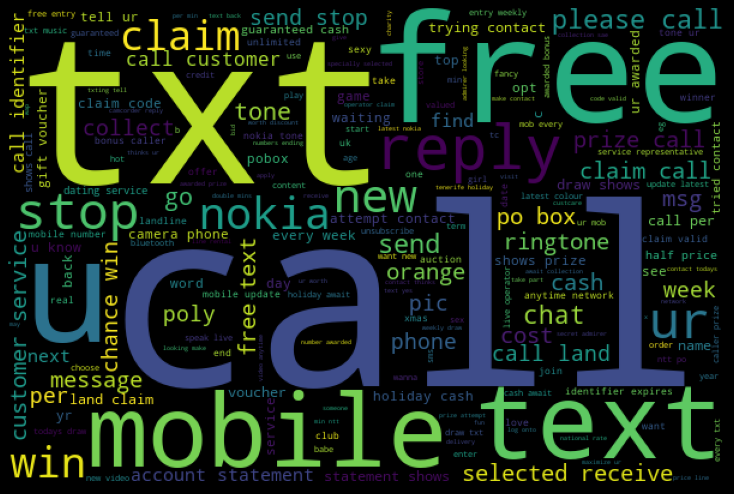

In [18]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
print("Top 10 Spam words are :\n")
print(pd.Series(spam_words).value_counts().head(10))

Top 10 Spam words are :

call      331
free      146
txt       136
ur        129
mobile    108
text      107
claim     105
u          98
reply      98
stop       78
dtype: int64


In [20]:
ham_words = text_preprocess(ham_messages)

In [21]:
ham_words[:10]

['go',
 'jurong',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'cine']

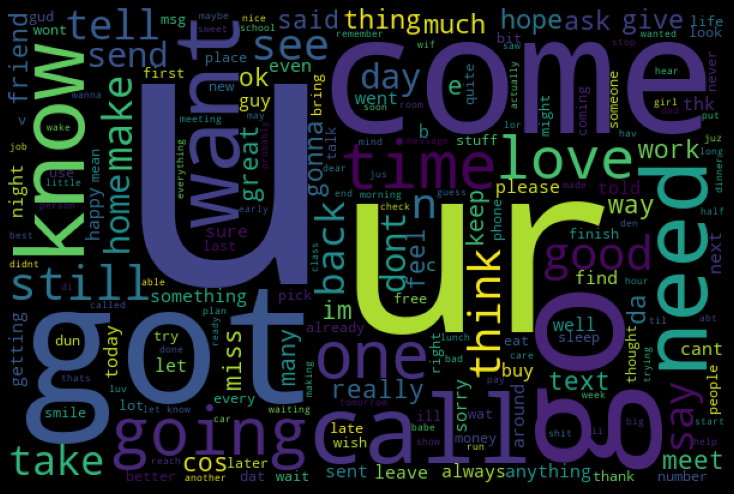

In [22]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [23]:
print("Top 10 Ham words are :\n")
print(pd.Series(ham_words).value_counts().head(10))

Top 10 Ham words are :

u        820
get      287
ur       235
go       231
got      216
like     215
know     202
come     201
call     200
going    151
dtype: int64


In [24]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [25]:
# Remove punctuations/stopwords  
messages["message"] = messages["message"].apply(text_preprocess)

In [26]:
# Conver the SMS into string from list
messages["message"] = messages["message"].agg(lambda x: ' '.join(map(str, x)))

In [27]:
messages.head()

,label,message,length
0,ham,go jurong point crazy available bugis n great ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry wkly comp win fa cup final tkts may...,155
3,ham,u dun say early hor u c already say,49
4,ham,nah dont think goes usf lives around though,61


# Bag of Words

In [28]:
# Creating the Bag of Words
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(messages['message'])

print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names()[20:40])

print("\nTotal number of vocab words : ",len(vectorizer.vocabulary_))

20 Bag of Words (BOW) Features: 

['absence', 'absolutely', 'abstract', 'abt', 'abta', 'aburo', 'abuse', 'abusers', 'ac', 'academic', 'acc', 'accent', 'accenture', 'accept', 'access', 'accessible', 'accidant', 'accident', 'accidentally', 'accommodation']

Total number of vocab words :  8084


In [29]:
message4 = messages['message'][3]
print(message4)

u dun say early hor u c already say


In [30]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 207)	1
  (0, 1981)	1
  (0, 2000)	1
  (0, 3141)	1
  (0, 5945)	2
(1, 8084)


In [31]:
print(bow_transformer.get_feature_names()[5945])

say


In [32]:
messages_bow = bow_transformer.transform(messages['message'])

In [33]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 8084)
Amount of Non-Zero occurences:  44211


In [34]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [35]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 5945)	0.6206136295983186
  (0, 3141)	0.5139528069861297
  (0, 2000)	0.37127907512470754
  (0, 1981)	0.3420160440299522
  (0, 207)	0.3096257562744466


In [36]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['say']])

5.14835197309133


In [37]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 8084)


In [38]:
messages["message"][:10]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts may...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
5    freemsg hey darling weeks word back id like fu...
6       even brother like speak treat like aids patent
7    per request melle melle oru minnaminunginte nu...
8    winner valued network customer selected receiv...
9    mobile months u r entitled update latest colou...
Name: message, dtype: object

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["message"])
print(features.shape)

print(len(vec.vocabulary_))

(5572, 7927)
7927


# Model Evaluation

In [40]:
msg_train, msg_test, label_train, label_test = train_test_split(messages_tfidf, messages['label'], test_size=0.2)

In [41]:
print("train dataset features size : ",msg_train.shape)
print("train dataset label size", label_train.shape)

print("\n")

print("test dataset features size", msg_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (4457, 8084)
train dataset label size (4457,)


test dataset features size (1115, 8084)
test dataset lable size (1115,)


In [42]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression 

MNB = MultinomialNB()
spam_detect_model1 = MNB.fit(msg_train, label_train)

svclassifier = SVC(kernel='linear')
spam_detect_model2 = svclassifier.fit(msg_train, label_train)


logistic = LogisticRegression()
spam_detect_model3 = logistic.fit(msg_train, label_train)




In [43]:
predict_train1 = spam_detect_model1.predict(msg_train)
predict_train2 = spam_detect_model2.predict(msg_train)
predict_train3 = spam_detect_model3.predict(msg_train)

In [44]:
print("Classification Report(MNB) \n",metrics.classification_report(label_train, predict_train1))
print("Classification Report(LSVM) \n",metrics.classification_report(label_train, predict_train2))
print("Classification Report(LOGISTIC) \n",metrics.classification_report(label_train, predict_train3))
print("\n")
print("\n")
print("Confusion Matrix(MNB) \n",metrics.confusion_matrix(label_train, predict_train1))
print("Confusion Matrix(LSVM) \n",metrics.confusion_matrix(label_train, predict_train2))
print("Confusion Matrix(LOGISTIC) \n",metrics.confusion_matrix(label_train, predict_train3))
print("\n")
print("\n")
print("Accuracy of Train dataset(MNB) : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train1)))
print("Accuracy of Train dataset(LSVM) : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train2)))
print("Accuracy of Train dataset(LOGISTIC) : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train3)))

Classification Report(MNB) 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3849
        spam       1.00      0.82      0.90       608

    accuracy                           0.98      4457
   macro avg       0.99      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457

Classification Report(LSVM) 
               precision    recall  f1-score   support

         ham       0.99      1.00      1.00      3849
        spam       0.99      0.96      0.98       608

    accuracy                           0.99      4457
   macro avg       0.99      0.98      0.99      4457
weighted avg       0.99      0.99      0.99      4457

Classification Report(LOGISTIC) 
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98      3849
        spam       0.99      0.76      0.86       608

    accuracy                           0.97      4457
   macro avg       0.98      0.88  

In [45]:
print('predicted:', spam_detect_model1.predict(tfidf4)[0])
print('expected:', messages['label'][3])

predicted: ham
expected: ham


In [46]:
label_predictions = spam_detect_model1.predict(msg_test)
print(label_predictions)

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


In [47]:
print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       976
        spam       1.00      0.66      0.80       139

    accuracy                           0.96      1115
   macro avg       0.98      0.83      0.89      1115
weighted avg       0.96      0.96      0.95      1115

[[976   0]
 [ 47  92]]


In [48]:
# Printing the Overall Accuracy of the model
print("Accuracy of the model(MNB) : {0:0.3f}".format(metrics.accuracy_score(label_test, label_predictions)))

Accuracy of the model(MNB) : 0.958


# LSTM

In [49]:
df=pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')

In [50]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [51]:
#Drop unuse columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [52]:
#Rename columns
df.rename(columns={'v1':'target','v2':'sms'},inplace=True)

In [53]:
from sklearn.preprocessing import LabelEncoder

In [54]:
le=LabelEncoder()

In [55]:
df['target']=le.fit_transform(df['target'])

In [56]:
x=df['sms']
y=df['target']

In [57]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)

In [58]:
max_words=1000
max_len=172
token=Tokenizer(num_words=max_words)
token.fit_on_texts(df['sms'])
sequences=token.texts_to_sequences(x_train)
sequences_metrix=sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

In [59]:
# process test data
test_sequences = token.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,padding='post',maxlen=max_len)

In [60]:
model=Sequential()

#Embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

#LSTM layer
model.add(LSTM(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
#Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer


    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

# Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 172, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 172, 100)          60400     
_________________________________________________________________
flatten (Flatten)            (None, 17200)             0         
_________________________________________________________________
hl1 (Dense)                  (None, 200)               3440200   
_________________________________________________________________
hl2 (Dense)                  (None, 100)               20100     
_________________________________________________________________
ol (Dense)                   (None, 1)                 101       
Total params: 3,570,801
Trainable params: 3,570,801
Non-trainable params: 0
______________________________________________

In [61]:
#Shape of train dataset
sequences_metrix.shape,y_train.shape

((4457, 172), (4457,))

In [62]:
#Shape of test dataset
test_sequences_matrix.shape,y_test.shape

((1115, 172), (1115,))

In [63]:
#Train model
history=model.fit(sequences_metrix,y_train,batch_size=150,epochs=20,callbacks=[es],validation_split=0.2,verbose=1)

Epoch 1/20
24/24 [==============================] - 10s 321ms/step - loss: 0.4340 - accuracy: 0.8672 - val_loss: 0.1806 - val_accuracy: 0.9563
Epoch 2/20
24/24 [==============================] - 7s 294ms/step - loss: 0.1704 - accuracy: 0.9657 - val_loss: 0.0605 - val_accuracy: 0.9809
Epoch 3/20
24/24 [==============================] - 7s 286ms/step - loss: 0.0591 - accuracy: 0.9825 - val_loss: 0.0751 - val_accuracy: 0.9798
Epoch 4/20
24/24 [==============================] - 7s 288ms/step - loss: 0.0515 - accuracy: 0.9868 - val_loss: 0.0490 - val_accuracy: 0.9888
Epoch 5/20
24/24 [==============================] - 7s 289ms/step - loss: 0.0347 - accuracy: 0.9883 - val_loss: 0.0590 - val_accuracy: 0.9865
Epoch 6/20
24/24 [==============================] - 7s 282ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0455 - val_accuracy: 0.9877
Epoch 7/20
24/24 [==============================] - 7s 277ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.0637 - val_accuracy: 0.9877
Epoch

In [64]:
#Evaluation model
train_acc=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate

35/35 [==============================] - 1s 24ms/step - loss: 0.0820 - accuracy: 0.9857


In [65]:
#Train dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc[0],train_acc[1])) 

Loss:0.020 and Accuracy:0.995


In [66]:
#Test dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc[0],test_acc[1])) 

Loss:0.082 and Accuracy:0.986


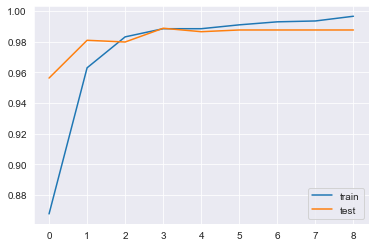

In [67]:
#Plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()